# Reto Housing Kaggle

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Exploración

In [155]:
train_data = "data/train.csv"

# 4 later
test_data = "data/test.csv"

df_train = pd.read_csv(train_data)
print(f"Shape of data: {df_train.shape}")
df_train.head()


Shape of data: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [156]:
missing_perc = df_train.isna().mean() * 100
missing_selected = missing_perc[missing_perc > 40]


if (missing_perc > 0).any():
    print(missing_selected)
else:
    print("No missing values")

Alley          93.767123
MasVnrType     59.726027
FireplaceQu    47.260274
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


In [157]:
if (df_train.duplicated().any()):
    print("Duplicated values")
else:
    print("No duplicated values")

No duplicated values


## Plot functions

In [158]:
def plot_hist_per_columns(df, cols):
    if len(cols) > 1:
        N = 15
    else:
        N = 5
    try:
        fig, axs = plt.subplots(1, len(cols), figsize=(N, 5))
        for i, col in enumerate(cols):
            axs[i].hist(df[col])
            axs[i].set_title(col)
            axs[i].grid()
    except TypeError:
        axs.hist(df[cols])
        axs.set_title(cols)
        axs.grid()
    finally:
        fig.tight_layout()

def plot_scatter_per_columns(df, cols):
    if len(cols) > 1:
        N = 15
    else:
        N = 5
    try:
        fig, axs = plt.subplots(1, len(cols), figsize=(N, 5))
        for i, col in enumerate(cols):
            axs[i].scatter(df[col], df["SalePrice"])
            axs[i].set_title(col)
            axs[i].grid()
    except TypeError:
        axs.scatter(df[cols], df["SalePrice"])
        axs.set_title(cols)
        axs.grid()
    finally:
        fig.tight_layout()

def plot_hist_scatter_per_columns(df, col):
    try:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].set_title(f'Histogram of {col}')
        axs[0].hist(df[col])
        axs[0].grid()
        axs[1].set_title(f'Scatterplot of {col} vs SalePrice')
        axs[1].scatter(df[col], df["SalePrice"])
        axs[1].grid()
    finally:
        fig.tight_layout()

## Hypothesis Test Functions

In [159]:
def shapiro_wilk_test(data, print_results=True):
    statistic, pvalue = shapiro(data)
    if print_results:
        print(f"Shapiro-Wilk test statistic: {statistic:.4f}")
        print(f"p-value: {pvalue:.4f}")
    if pvalue < 0.05:
        if print_results:
            print("The data is not normally distributed.")
        return False
    else:
        if print_results:
            print("The data is normally distributed.")
        return True
    if print_results:
        print("\n")

In [160]:
# Checamos todos los "poarch"
porch_cols = [col for col in df_train.columns if "porch" in col.lower()]
porch_cols

['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

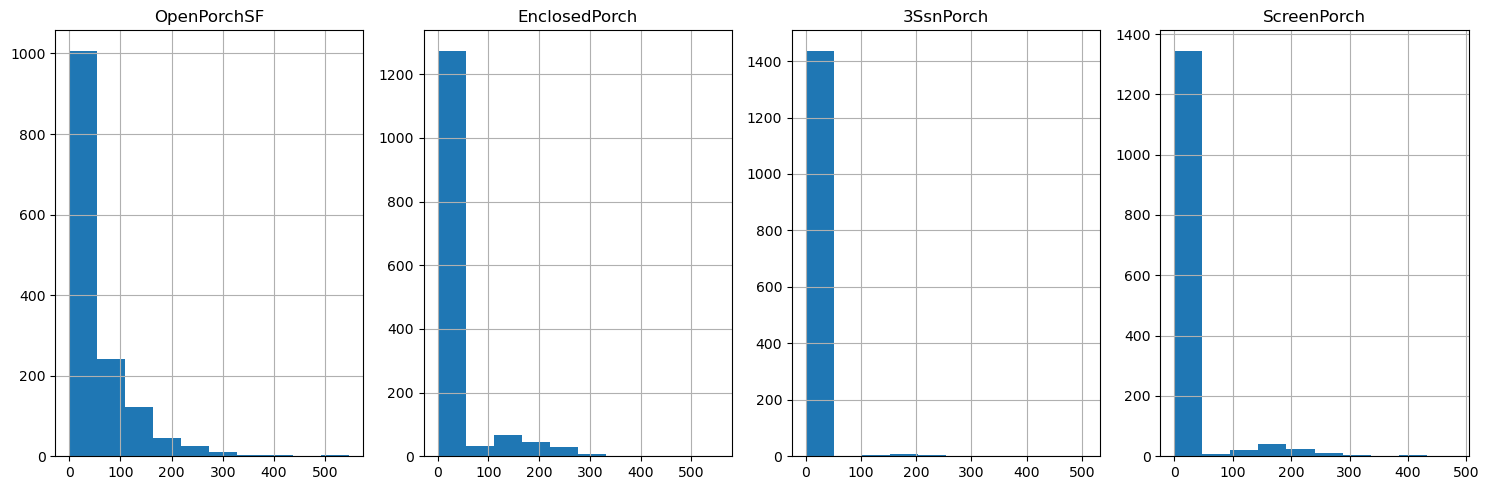

In [161]:
plot_hist_per_columns(df_train, porch_cols)

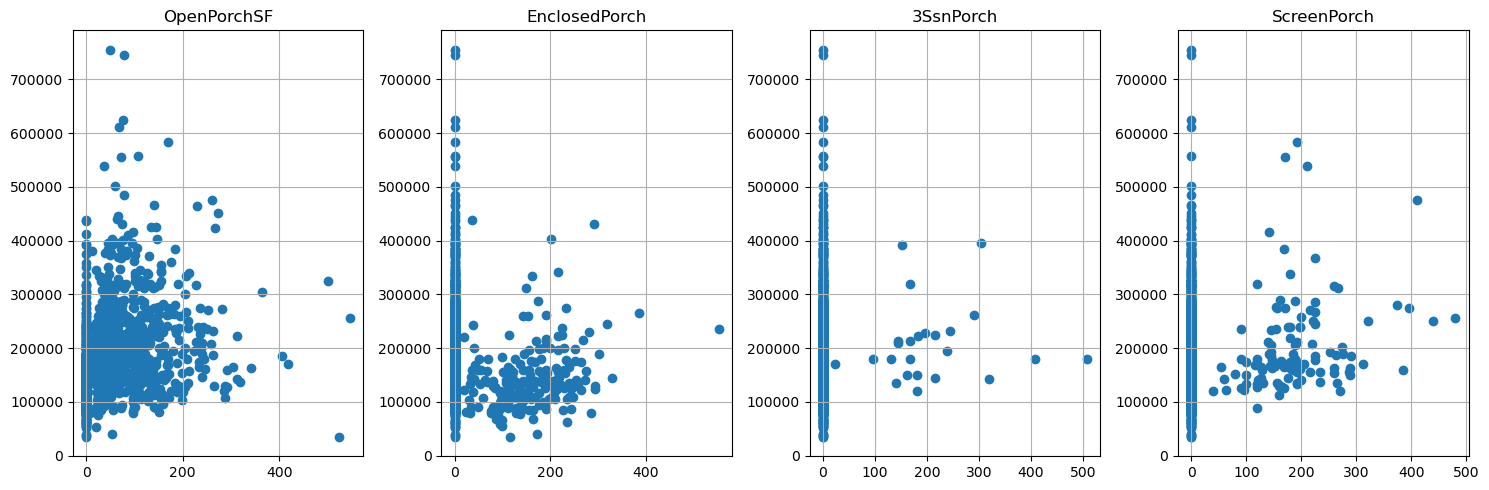

In [162]:
plot_scatter_per_columns(df_train, porch_cols)

Se decide eliminar "EnclosedPorch" y "ScreenPorch"

In [163]:
df_train_2 = df_train.drop(porch_cols[1:], axis=1)
df_train_2

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [164]:
df_train_2_numerics = df_train_2.select_dtypes(include=np.number)
df_train_2_numerics.corr()['SalePrice'].sort_values(ascending=False).apply(lambda x: round(x, 5))

SalePrice       1.00000
OverallQual     0.79098
GrLivArea       0.70862
GarageCars      0.64041
GarageArea      0.62343
TotalBsmtSF     0.61358
1stFlrSF        0.60585
FullBath        0.56066
TotRmsAbvGrd    0.53372
YearBuilt       0.52290
YearRemodAdd    0.50710
GarageYrBlt     0.48636
MasVnrArea      0.47749
Fireplaces      0.46693
BsmtFinSF1      0.38642
LotFrontage     0.35180
WoodDeckSF      0.32441
2ndFlrSF        0.31933
OpenPorchSF     0.31586
HalfBath        0.28411
LotArea         0.26384
BsmtFullBath    0.22712
BsmtUnfSF       0.21448
BedroomAbvGr    0.16821
PoolArea        0.09240
MoSold          0.04643
BsmtFinSF2     -0.01138
BsmtHalfBath   -0.01684
MiscVal        -0.02119
Id             -0.02192
LowQualFinSF   -0.02561
YrSold         -0.02892
OverallCond    -0.07786
MSSubClass     -0.08428
KitchenAbvGr   -0.13591
Name: SalePrice, dtype: float64

## Analisis Variables Normales

In [168]:
vanilla_normal_cols = []
for col in df_train_2_numerics.columns:
    if shapiro_wilk_test(df_train_2_numerics[col], print_results = False):
        vanilla_normal_cols.append(col)

In [175]:
df_train_vanilla_normals = df_train_2_numerics[vanilla_normal_cols + ["SalePrice"]]
df_train_vanilla_normals.corr()['SalePrice'].sort_values(ascending=False).apply(lambda x: round(x, 5))

SalePrice      1.00000
GarageYrBlt    0.48636
MasVnrArea     0.47749
LotFrontage    0.35180
Name: SalePrice, dtype: float64

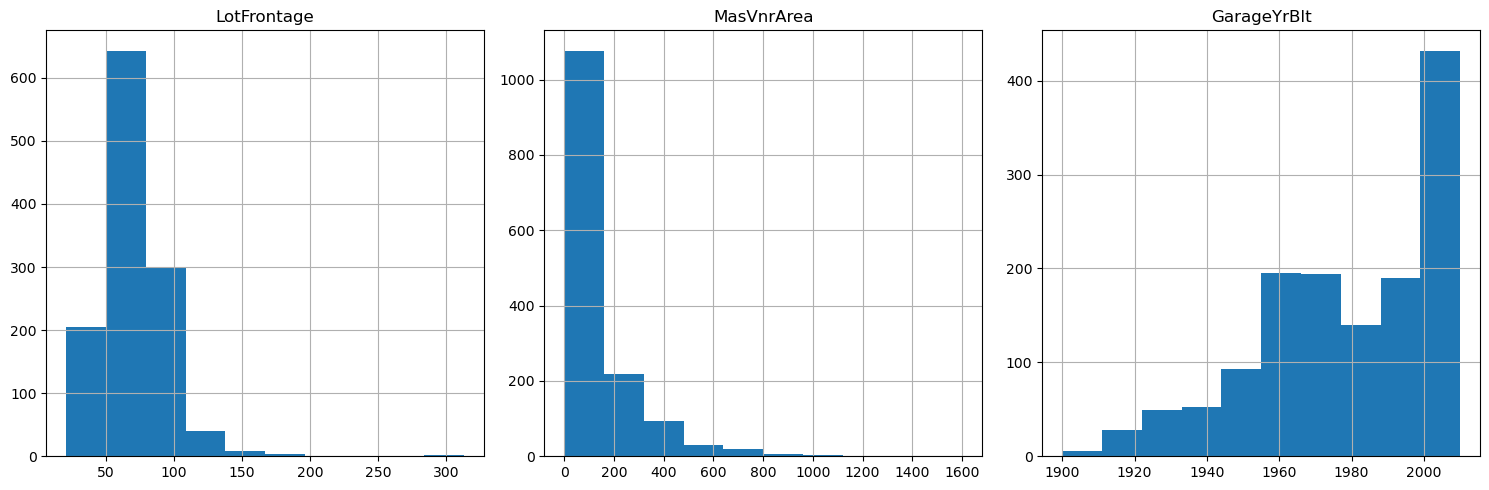

In [176]:
plot_hist_per_columns(df_train_vanilla_normals, vanilla_normal_cols)

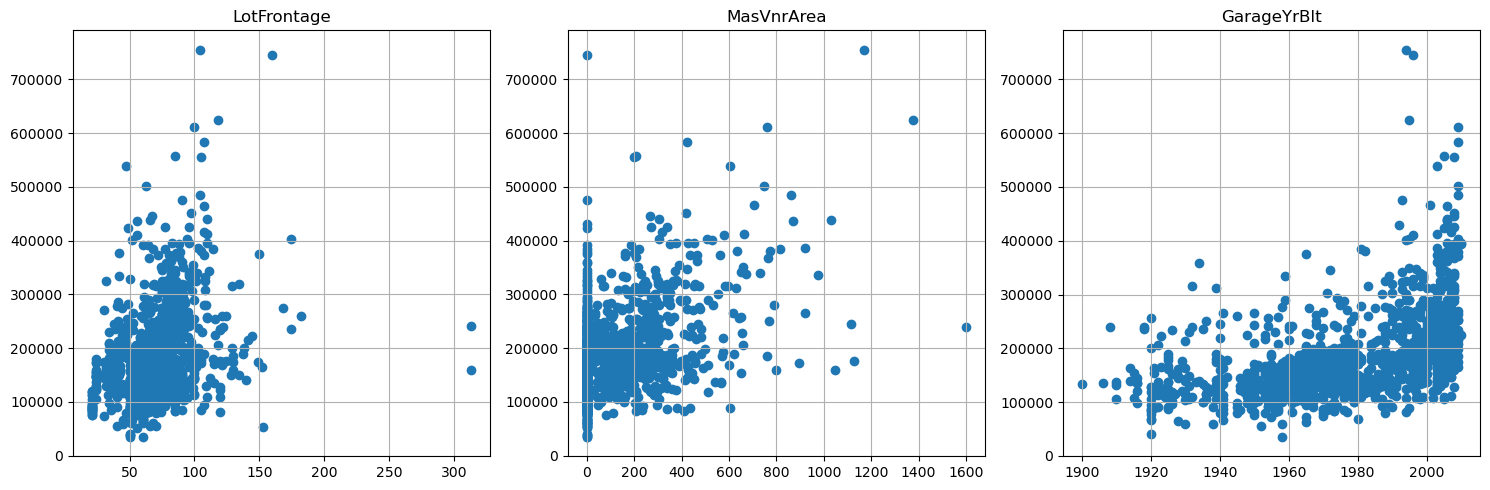

In [178]:
plot_scatter_per_columns(df_train_vanilla_normals, vanilla_normal_cols)